This tries to (at least partially) assess how many Pauli twirled version of the circuit we need for some fixed number of qubits (but larger than 3).

This simulates 7 qubits.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from pyquil import Program
from pyquil.api import WavefunctionSimulator
from pyquil.gates import *
from pyquil.paulis import *

import numpy as np
import itertools
import functools

from datetime import datetime
from functools import reduce
from tqdm import tqdm

from collections import defaultdict

import sys

In [2]:
n_qubits = 7
qubits = list(range(n_qubits))
dim = 2**n_qubits

In [3]:
graph = [(i, i+1) for i in range(n_qubits-1)]
print(graph)

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]


### Gates

Use the hand-compiled version for p=1

In [4]:
h = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]])
idty = np.eye(2)
x = np.array([[0, 1], [1, 0]])
y = np.array([[0, -1j], [1j, 0]])
z = np.array([[1, 0], [0, -1]])
p0 = np.array([[1, 0], [0, 0]])
p1 = np.array([[0, 0], [0, 1]])

def hadamard(q):
    global n_qubits
    mat_list = [idty]*(n_qubits-1-q) + [h] + [idty]*q
    operator = reduce(np.kron, mat_list)
    return operator

def global_hadamards():
    global n_qubits
    mat_list = [h]*n_qubits
    operator = reduce(np.kron, mat_list)
    return operator

def almost_global_rzs(gamma):
    global n_qubits
    rz = np.cos(gamma)*idty - 1j*np.sin(gamma)*z
    mat_list = [rz]*(n_qubits-1) + [idty]
    operator = reduce(np.kron, mat_list)
    return operator

def almost_global_hadamards():
    global n_qubits
    mat_list = [h]*(n_qubits-1) + [idty]
    operator = reduce(np.kron, mat_list)
    return operator

def cz(qc, qt):
    global n_qubits
    qA = max([int(q) for q in [qc, qt]])
    qB = min([int(q) for q in [qc, qt]])
    if (qA==qc) and (qB==qt):
        p0_part_mats = [idty]*(n_qubits-1-qA) + [p0] + [idty]*(qA-qB-1) + [idty] + [idty]*qB
        p1_part_mats = [idty]*(n_qubits-1-qA) + [p1] + [idty]*(qA-qB-1) + [z] + [idty]*qB
    elif (qA==qt) and (qB==qc):
        p0_part_mats = [idty]*(n_qubits-1-qA) + [idty] + [idty]*(qA-qB-1) + [p0] + [idty]*qB
        p1_part_mats = [idty]*(n_qubits-1-qA) + [z] + [idty]*(qA-qB-1) + [p1] + [idty]*qB
    else:
        raise ValueError("something went wrong")
    p0_part = reduce(np.kron, p0_part_mats)
    p1_part = reduce(np.kron, p1_part_mats)
    operator = p0_part + p1_part
    return operator

def mixer_term(beta):
    global n_qubits
    rx = np.cos(beta)*idty - 1j*np.sin(beta)*x
    mat_list = [rx]*n_qubits
    operator = reduce(np.kron, mat_list)
    return operator

def zz_term(q1, q2):
    global n_qubits
    qA = max([int(q) for q in [q1, q2]])
    qB = min([int(q) for q in [q1, q2]])
    zz_term_list = [idty]*(n_qubits-1-qA) + [z] + [idty]*(qA-qB-1) + [z] + [idty]*qB
    zz_term = reduce(np.kron, zz_term_list)
    return zz_term

### Sanity check: Make sure we get same landscape

First, with the wavefunction simulator

100%|██████████| 625/625 [00:07<00:00, 84.93it/s]


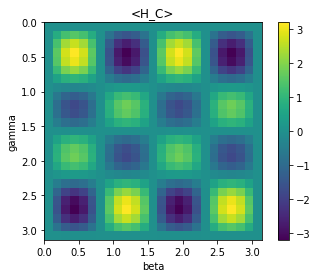

In [5]:
hamiltonian = 0.0
for (i,j) in graph:
    hamiltonian += sZ(i)*sZ(j)
    
mixer = 0.0
for q in qubits:
    mixer += sX(q)
    
wfn_sim = WavefunctionSimulator()

wfn_prog = Program()
wfn_gamma = wfn_prog.declare('gamma', 'REAL', 1)
wfn_beta = wfn_prog.declare('beta', 'REAL', 1)

for q in qubits:
    wfn_prog += H(q)
for ham_term in hamiltonian:
    wfn_prog += exponential_map(ham_term)(wfn_gamma)
for mix_term in mixer:
    wfn_prog += exponential_map(mix_term)(wfn_beta)
    
width = 25
angle_range = np.linspace(0.0, np.pi, width)

wfn_expectations = []

for (gamma, beta) in tqdm(list(itertools.product(angle_range, angle_range))):
    wfn_expect = wfn_sim.expectation(wfn_prog, hamiltonian, memory_map={'gamma': [gamma], 'beta': [beta]})
    assert np.isclose(np.imag(wfn_expect), 0.0)
    wfn_expectations.append(np.real(wfn_expect))
    
wfn_expectations = np.array(wfn_expectations).reshape(width, width)
plt.imshow(wfn_expectations, extent=[0.0, np.pi, np.pi, 0.0])
plt.colorbar()
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('<H_C>')
plt.show()

Next, with our density matrix simulator

100%|██████████| 625/625 [00:11<00:00, 53.86it/s]


True


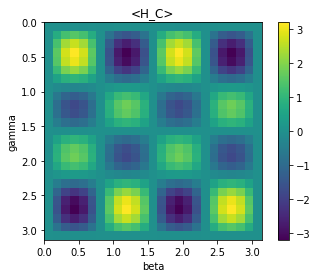

In [6]:
Zexpectations = []

for (gamma, beta) in tqdm(list(itertools.product(angle_range, angle_range))):

    # initial state
    p0_list = [p0]*n_qubits
    rho = reduce(np.kron, p0_list)
    
    # initial hadamards
    had_op = global_hadamards()
    rho = had_op @ rho @ had_op.conj().T
    
    # almost global RZs
    rz_op = almost_global_rzs(gamma)
    rho = rz_op @ rho @ rz_op.conj().T
    
    # almost global hadamards
    had_op2 = almost_global_hadamards()
    rho = had_op2 @ rho @ had_op2.conj().T
    
    # CZ ladder
    for idx, _ in enumerate(qubits[:-1]):

        # CZ operation
        cz_op = cz(qubits[idx], qubits[idx+1])
        rho = cz_op @ rho @ cz_op.conj().T
        
        # post-CZ Hadamard operation
        h_op = hadamard(qubits[idx+1])
        rho = h_op @ rho @ h_op.conj().T
        
    # mixer term
    mix_op = mixer_term(beta)
    rho = mix_op @ rho @ mix_op.conj().T
    
    # calculate expectation value of H_C
    Zexpect = 0.0
    for idx, _ in enumerate(qubits[:-1]):
        zzterm = zz_term(qubits[idx], qubits[idx+1])
        Zexpect += np.trace(zzterm @ rho)
        
    assert np.isclose(np.imag(Zexpect), 0.0), f"(gamma, beta): {(gamma, beta)}; Zexpect: {Zexpect}"
    Zexpectations.append(np.real(Zexpect))
    
Zexpectations = np.array(Zexpectations).reshape(width, width)
print(np.allclose(Zexpectations, wfn_expectations))
plt.imshow(Zexpectations, extent=[0.0, np.pi, np.pi, 0.0])
plt.colorbar()
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('<H_C>')
plt.show()

Now, make sure that Pauli twirling gives the same result as the ideal one in the absence of any noise.

In [7]:
def c(a, b):
    return int(a + b*(3-b)*(3-2*a)/2)

def d(a, b):
    return int(b + a*(3-a)*(3-2*b)/2)

def pauli_op(i, q):
    global n_qubits
    d_idx_op = {0: idty, 1: x, 2: y, 3: z}
    mat_list = [idty]*(n_qubits-1-q) + [d_idx_op[i]] + [idty]*q
    operator = reduce(np.kron, mat_list)
    return operator

Working on experiment: 1

100%|██████████| 625/625 [00:23<00:00, 26.78it/s]

Working on experiment: 2


100%|██████████| 625/625 [00:23<00:00, 27.09it/s]

Working on experiment: 3


100%|██████████| 625/625 [00:22<00:00, 27.94it/s]

Working on experiment: 4


100%|██████████| 625/625 [00:23<00:00, 27.13it/s]

Working on experiment: 5


100%|██████████| 625/625 [00:21<00:00, 28.52it/s]


True


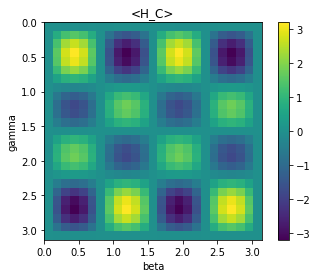

In [8]:
## Several experiments

n_expts = 5
rand_idxs_expts = np.random.choice([0, 1, 2, 3], size=n_expts * (2*n_qubits - 2)).reshape(n_expts, -1)

twirled_expectations = np.zeros((width, width))

for count_expts, rand_idxs in enumerate(rand_idxs_expts):
    
    print(f"\rWorking on experiment: {count_expts+1}", end="")
    sys.stdout.flush()
    
    expectations = []
    
    for (gamma, beta) in tqdm(list(itertools.product(angle_range, angle_range))):

        # initial state
        p0_list = [p0]*n_qubits
        rho = reduce(np.kron, p0_list)

        # initial hadamards
        had_op = global_hadamards()
        rho = had_op @ rho @ had_op.conj().T

        # almost global RZs
        rz_op = almost_global_rzs(gamma)
        rho = rz_op @ rho @ rz_op.conj().T

        # almost global hadamards
        had_op2 = almost_global_hadamards()
        rho = had_op2 @ rho @ had_op2.conj().T

        # CZ ladder
        for idx, _ in enumerate(qubits[:-1]):
            
            # identify twirling operators
            A = rand_idxs[2*idx]
            B = rand_idxs[2*idx+1]
            C = c(A, B)
            D = d(A, B)
            pauli_A = pauli_op(A, qubits[idx])
            pauli_B = pauli_op(B, qubits[idx+1])
            pauli_C = pauli_op(C, qubits[idx])
            pauli_D = pauli_op(D, qubits[idx+1])
            
            # insert pre-twirl here
            pre_twirl = pauli_A @ pauli_B
            rho = pre_twirl @ rho @ pre_twirl.conj().T

            # CZ operation
            cz_op = cz(qubits[idx], qubits[idx+1])
            rho = cz_op @ rho @ cz_op.conj().T
            
            # insert post-twirl here
            post_twirl = pauli_C @ pauli_D
            rho = post_twirl @ rho @ post_twirl.conj().T

            # post-CZ Hadamard operation
            h_op = hadamard(qubits[idx+1])
            rho = h_op @ rho @ h_op.conj().T

        # mixer term
        mix_op = mixer_term(beta)
        rho = mix_op @ rho @ mix_op.conj().T

        # calculate expectation value of H_C
        Zexpect = 0.0
        for idx, _ in enumerate(qubits[:-1]):
            zzterm = zz_term(qubits[idx], qubits[idx+1])
            Zexpect += np.trace(zzterm @ rho)

        assert np.isclose(np.imag(Zexpect), 0.0), f"(gamma, beta): {(gamma, beta)}; Zexpect: {Zexpect}"
        expectations.append(np.real(Zexpect))

    expectations = np.array(expectations).reshape(width, width)
    twirled_expectations += expectations
    
twirled_expectations /= n_expts
print(np.allclose(twirled_expectations, wfn_expectations))
plt.imshow(twirled_expectations, extent=[0.0, np.pi, np.pi, 0.0])
plt.colorbar()
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('<H_C>')
plt.show()

### Noise

Now, we add some noise to distort the landscape

In [9]:
def damping_after_dephasing(p, q):
    K1damp = np.array([[1, 0], [0, np.sqrt(1-p)]])
    K2damp = np.array([[0, np.sqrt(p)], [0, 0]])
    K1deph = np.array([[np.sqrt(1-q), 0], [0, np.sqrt(1-q)]])
    K2deph = np.array([[np.sqrt(q), 0], [0, -np.sqrt(q)]])
    kraus_ops = [K1damp @ K1deph, K1damp @ K2deph,
                 K2damp @ K1deph, K2damp @ K2deph]
    return kraus_ops

In [10]:
prob_damp = 0.4
prob_deph = 0.4
oneq_noise = damping_after_dephasing(prob_damp, prob_deph)
twoq_noise = [np.kron(k1, k2) for k1 in oneq_noise for k2 in oneq_noise]

100%|██████████| 625/625 [01:04<00:00,  9.68it/s]


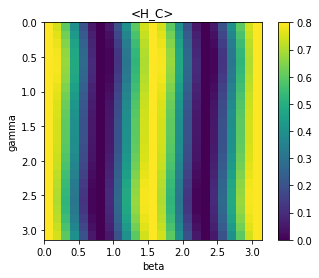

In [11]:
Zexpectations_noisy = []

for (gamma, beta) in tqdm(list(itertools.product(angle_range, angle_range))):

    # initial state
    p0_list = [p0]*n_qubits
    rho = reduce(np.kron, p0_list)
    
    # initial hadamards
    had_op = global_hadamards()
    rho = had_op @ rho @ had_op.conj().T
    
    # almost global RZs
    rz_op = almost_global_rzs(gamma)
    rho = rz_op @ rho @ rz_op.conj().T
    
    # almost global hadamards
    had_op2 = almost_global_hadamards()
    rho = had_op2 @ rho @ had_op2.conj().T
    
    # CZ ladder
    for idx, _ in enumerate(qubits[:-1]):

        # CZ operation
        cz_op = cz(qubits[idx], qubits[idx+1])
        rho = cz_op @ rho @ cz_op.conj().T
        
        # CZ noise
        rho_mod = np.zeros((dim, dim), dtype='complex128')
        qA = qubits[idx]
        noise_ops = [reduce(np.kron, [idty]*(n_qubits-2-qA) + [noise_op] + [idty]*qA) for noise_op in twoq_noise]
        for K in noise_ops:
            rho_mod += K @ rho @ K.conj().T
        rho = rho_mod
        
        # post-CZ Hadamard operation
        h_op = hadamard(qubits[idx+1])
        rho = h_op @ rho @ h_op.conj().T
        
    # mixer term
    mix_op = mixer_term(beta)
    rho = mix_op @ rho @ mix_op.conj().T
    
    # calculate expectation value of H_C
    Zexpect = 0.0
    for idx, _ in enumerate(qubits[:-1]):
        zzterm = zz_term(qubits[idx], qubits[idx+1])
        Zexpect += np.trace(zzterm @ rho)
        
    assert np.isclose(np.imag(Zexpect), 0.0), f"(gamma, beta): {(gamma, beta)}; Zexpect: {Zexpect}"
    Zexpectations_noisy.append(np.real(Zexpect))
    
Zexpectations_noisy = np.array(Zexpectations_noisy).reshape(width, width)
plt.imshow(Zexpectations_noisy, extent=[0.0, np.pi, np.pi, 0.0])
plt.colorbar()
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('<H_C>')
plt.show()

Next, let's perform Pauli twirling in the presence of noise to turn the damping-after-dephasing channels into stochastic channels. First, we briefly comment out the parts that perform the twirling to make sure we get the same landscape as above.

Working on experiment: 1

100%|██████████| 625/625 [01:01<00:00, 10.08it/s]

Working on experiment: 2


100%|██████████| 625/625 [01:05<00:00,  9.59it/s]

Working on experiment: 3


100%|██████████| 625/625 [01:07<00:00,  9.26it/s]

Working on experiment: 4


100%|██████████| 625/625 [01:07<00:00,  9.21it/s]

Working on experiment: 5


100%|██████████| 625/625 [01:07<00:00,  9.20it/s]


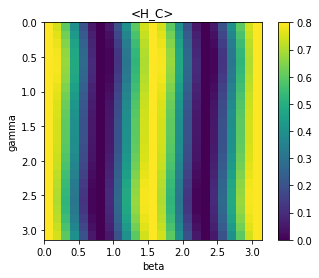

In [12]:
## Several experiments

n_expts = 5
rand_idxs_expts = np.random.choice([0, 1, 2, 3], size=n_expts * (2*n_qubits - 2)).reshape(n_expts, -1)

twirled_noisy_expectations = np.zeros((width, width))

for count_expts, rand_idxs in enumerate(rand_idxs_expts):
    
    print(f"\rWorking on experiment: {count_expts+1}", end="")
    sys.stdout.flush()
    
    expectations = []
    
    for (gamma, beta) in tqdm(list(itertools.product(angle_range, angle_range))):

        # initial state
        p0_list = [p0]*n_qubits
        rho = reduce(np.kron, p0_list)

        # initial hadamards
        had_op = global_hadamards()
        rho = had_op @ rho @ had_op.conj().T

        # almost global RZs
        rz_op = almost_global_rzs(gamma)
        rho = rz_op @ rho @ rz_op.conj().T

        # almost global hadamards
        had_op2 = almost_global_hadamards()
        rho = had_op2 @ rho @ had_op2.conj().T

        # CZ ladder
        for idx, _ in enumerate(qubits[:-1]):
            
            # identify twirling operators
            A = rand_idxs[2*idx]
            B = rand_idxs[2*idx+1]
            C = c(A, B)
            D = d(A, B)
            pauli_A = pauli_op(A, qubits[idx])
            pauli_B = pauli_op(B, qubits[idx+1])
            pauli_C = pauli_op(C, qubits[idx])
            pauli_D = pauli_op(D, qubits[idx+1])
            
#             # insert pre-twirl here
#             pre_twirl = pauli_A @ pauli_B
#             rho = pre_twirl @ rho @ pre_twirl.conj().T

            # CZ operation
            cz_op = cz(qubits[idx], qubits[idx+1])
            rho = cz_op @ rho @ cz_op.conj().T
            
            # CZ noise
            rho_mod = np.zeros((dim, dim), dtype='complex128')
            qA = qubits[idx]
            noise_ops = [reduce(np.kron, [idty]*(n_qubits-2-qA) + [noise_op] + [idty]*qA) for noise_op in twoq_noise]
            for K in noise_ops:
                rho_mod += K @ rho @ K.conj().T
            rho = rho_mod
            
#             # insert post-twirl here
#             post_twirl = pauli_C @ pauli_D
#             rho = post_twirl @ rho @ post_twirl.conj().T

            # post-CZ Hadamard operation
            h_op = hadamard(qubits[idx+1])
            rho = h_op @ rho @ h_op.conj().T

        # mixer term
        mix_op = mixer_term(beta)
        rho = mix_op @ rho @ mix_op.conj().T

        # calculate expectation value of H_C
        Zexpect = 0.0
        for idx, _ in enumerate(qubits[:-1]):
            zzterm = zz_term(qubits[idx], qubits[idx+1])
            Zexpect += np.trace(zzterm @ rho)

        assert np.isclose(np.imag(Zexpect), 0.0), f"(gamma, beta): {(gamma, beta)}; Zexpect: {Zexpect}"
        expectations.append(np.real(Zexpect))

    expectations = np.array(expectations).reshape(width, width)
    twirled_noisy_expectations += expectations
    
twirled_noisy_expectations /= n_expts
# print(np.allclose(twirled_expectations, wfn_expectations))
plt.imshow(twirled_noisy_expectations, extent=[0.0, np.pi, np.pi, 0.0])
plt.colorbar()
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('<H_C>')
plt.show()

Now, we add in the twirling operations.

Working on experiment: 1

100%|██████████| 625/625 [01:11<00:00,  8.70it/s]

Working on experiment: 2


100%|██████████| 625/625 [01:11<00:00,  8.76it/s]

Working on experiment: 3


100%|██████████| 625/625 [01:11<00:00,  8.69it/s]

Working on experiment: 4


100%|██████████| 625/625 [01:11<00:00,  8.70it/s]

Working on experiment: 5


100%|██████████| 625/625 [01:12<00:00,  8.67it/s]

Working on experiment: 6


100%|██████████| 625/625 [01:14<00:00,  8.39it/s]

Working on experiment: 7


100%|██████████| 625/625 [01:13<00:00,  8.52it/s]

Working on experiment: 8


100%|██████████| 625/625 [01:13<00:00,  8.53it/s]

Working on experiment: 9


100%|██████████| 625/625 [01:14<00:00,  8.38it/s]

Working on experiment: 10


100%|██████████| 625/625 [01:13<00:00,  8.52it/s]

Working on experiment: 11


100%|██████████| 625/625 [01:13<00:00,  8.45it/s]

Working on experiment: 12


100%|██████████| 625/625 [01:14<00:00,  8.41it/s]

Working on experiment: 13


100%|██████████| 625/625 [01:13<00:00,  8.45it/s]

Working on experiment: 14


100%|██████████| 625/625 [01:14<00:00,  8.43it/s]

Working on experiment: 15


100%|██████████| 625/625 [01:13<00:00,  8.47it/s]

Working on experiment: 16


100%|██████████| 625/625 [01:14<00:00,  8.43it/s]

Working on experiment: 17


100%|██████████| 625/625 [01:13<00:00,  8.46it/s]

Working on experiment: 18


100%|██████████| 625/625 [01:13<00:00,  8.48it/s]

Working on experiment: 19


100%|██████████| 625/625 [01:13<00:00,  8.56it/s]

Working on experiment: 20


100%|██████████| 625/625 [01:13<00:00,  8.55it/s]

Working on experiment: 21


100%|██████████| 625/625 [01:13<00:00,  8.55it/s]

Working on experiment: 22


100%|██████████| 625/625 [01:13<00:00,  8.53it/s]

Working on experiment: 23


100%|██████████| 625/625 [01:13<00:00,  8.50it/s]

Working on experiment: 24


100%|██████████| 625/625 [01:13<00:00,  8.49it/s]

Working on experiment: 25


100%|██████████| 625/625 [01:13<00:00,  8.53it/s]

Working on experiment: 26


100%|██████████| 625/625 [01:13<00:00,  8.45it/s]

Working on experiment: 27


100%|██████████| 625/625 [01:14<00:00,  8.38it/s]

Working on experiment: 28


100%|██████████| 625/625 [01:13<00:00,  8.54it/s]

Working on experiment: 29


100%|██████████| 625/625 [01:13<00:00,  8.52it/s]

Working on experiment: 30


100%|██████████| 625/625 [01:13<00:00,  8.52it/s]

Working on experiment: 31


100%|██████████| 625/625 [01:13<00:00,  8.52it/s]

Working on experiment: 32


100%|██████████| 625/625 [01:13<00:00,  8.54it/s]

Working on experiment: 33


100%|██████████| 625/625 [01:13<00:00,  8.47it/s]

Working on experiment: 34


100%|██████████| 625/625 [01:13<00:00,  8.50it/s]

Working on experiment: 35


100%|██████████| 625/625 [01:13<00:00,  8.48it/s]

Working on experiment: 36


100%|██████████| 625/625 [01:13<00:00,  8.53it/s]

Working on experiment: 37


100%|██████████| 625/625 [01:13<00:00,  8.54it/s]

Working on experiment: 38


100%|██████████| 625/625 [01:12<00:00,  8.58it/s]

Working on experiment: 39


100%|██████████| 625/625 [01:13<00:00,  8.52it/s]

Working on experiment: 40


100%|██████████| 625/625 [01:13<00:00,  8.54it/s]


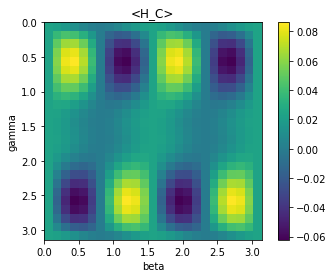

In [13]:
## Several experiments

n_expts = 40
rand_idxs_expts = np.random.choice([0, 1, 2, 3], size=n_expts * (2*n_qubits - 2)).reshape(n_expts, -1)

twirled_noisy_expectations = np.zeros((width, width))

for count_expts, rand_idxs in enumerate(rand_idxs_expts):
    
    print(f"\rWorking on experiment: {count_expts+1}", end="")
    sys.stdout.flush()
    
    expectations = []
    
    for (gamma, beta) in tqdm(list(itertools.product(angle_range, angle_range))):

        # initial state
        p0_list = [p0]*n_qubits
        rho = reduce(np.kron, p0_list)

        # initial hadamards
        had_op = global_hadamards()
        rho = had_op @ rho @ had_op.conj().T

        # almost global RZs
        rz_op = almost_global_rzs(gamma)
        rho = rz_op @ rho @ rz_op.conj().T

        # almost global hadamards
        had_op2 = almost_global_hadamards()
        rho = had_op2 @ rho @ had_op2.conj().T

        # CZ ladder
        for idx, _ in enumerate(qubits[:-1]):
            
            # identify twirling operators
            A = rand_idxs[2*idx]
            B = rand_idxs[2*idx+1]
            C = c(A, B)
            D = d(A, B)
            pauli_A = pauli_op(A, qubits[idx])
            pauli_B = pauli_op(B, qubits[idx+1])
            pauli_C = pauli_op(C, qubits[idx])
            pauli_D = pauli_op(D, qubits[idx+1])
            
            # insert pre-twirl here
            pre_twirl = pauli_A @ pauli_B
            rho = pre_twirl @ rho @ pre_twirl.conj().T

            # CZ operation
            cz_op = cz(qubits[idx], qubits[idx+1])
            rho = cz_op @ rho @ cz_op.conj().T
            
            # CZ noise
            rho_mod = np.zeros((dim, dim), dtype='complex128')
            qA = qubits[idx]
            noise_ops = [reduce(np.kron, [idty]*(n_qubits-2-qA) + [noise_op] + [idty]*qA) for noise_op in twoq_noise]
            for K in noise_ops:
                rho_mod += K @ rho @ K.conj().T
            rho = rho_mod
            
            # insert post-twirl here
            post_twirl = pauli_C @ pauli_D
            rho = post_twirl @ rho @ post_twirl.conj().T

            # post-CZ Hadamard operation
            h_op = hadamard(qubits[idx+1])
            rho = h_op @ rho @ h_op.conj().T

        # mixer term
        mix_op = mixer_term(beta)
        rho = mix_op @ rho @ mix_op.conj().T

        # calculate expectation value of H_C
        Zexpect = 0.0
        for idx, _ in enumerate(qubits[:-1]):
            zzterm = zz_term(qubits[idx], qubits[idx+1])
            Zexpect += np.trace(zzterm @ rho)

        assert np.isclose(np.imag(Zexpect), 0.0), f"(gamma, beta): {(gamma, beta)}; Zexpect: {Zexpect}"
        expectations.append(np.real(Zexpect))

    expectations = np.array(expectations).reshape(width, width)
    twirled_noisy_expectations += expectations
    
twirled_noisy_expectations /= n_expts
# print(np.allclose(twirled_expectations, wfn_expectations))
plt.imshow(twirled_noisy_expectations, extent=[0.0, np.pi, np.pi, 0.0])
plt.colorbar()
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('<H_C>')
plt.show()

#### 20 expts

Working on experiment: 1

100%|██████████| 625/625 [01:11<00:00,  8.76it/s]

Working on experiment: 2


100%|██████████| 625/625 [01:13<00:00,  8.48it/s]

Working on experiment: 3


100%|██████████| 625/625 [01:13<00:00,  8.49it/s]

Working on experiment: 4


100%|██████████| 625/625 [01:13<00:00,  8.46it/s]

Working on experiment: 5


100%|██████████| 625/625 [01:13<00:00,  8.50it/s]

Working on experiment: 6


100%|██████████| 625/625 [01:13<00:00,  8.48it/s]

Working on experiment: 7


100%|██████████| 625/625 [01:12<00:00,  8.57it/s]

Working on experiment: 8


100%|██████████| 625/625 [01:13<00:00,  8.46it/s]

Working on experiment: 9


100%|██████████| 625/625 [01:12<00:00,  8.58it/s]

Working on experiment: 10


100%|██████████| 625/625 [01:12<00:00,  8.58it/s]

Working on experiment: 11


100%|██████████| 625/625 [01:12<00:00,  8.58it/s]

Working on experiment: 12


100%|██████████| 625/625 [01:12<00:00,  8.60it/s]

Working on experiment: 13


100%|██████████| 625/625 [01:12<00:00,  8.57it/s]

Working on experiment: 14


100%|██████████| 625/625 [01:13<00:00,  8.54it/s]

Working on experiment: 15


100%|██████████| 625/625 [01:13<00:00,  8.54it/s]

Working on experiment: 16


100%|██████████| 625/625 [01:12<00:00,  8.59it/s]

Working on experiment: 17


100%|██████████| 625/625 [01:13<00:00,  8.53it/s]

Working on experiment: 18


100%|██████████| 625/625 [01:14<00:00,  8.40it/s]

Working on experiment: 19


100%|██████████| 625/625 [01:14<00:00,  8.42it/s]

Working on experiment: 20


100%|██████████| 625/625 [01:14<00:00,  8.41it/s]


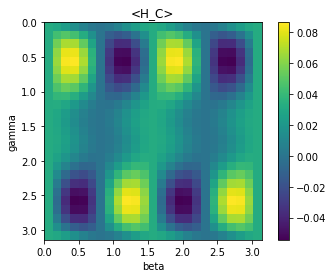

In [14]:
## Several experiments

n_expts = 20
rand_idxs_expts = np.random.choice([0, 1, 2, 3], size=n_expts * (2*n_qubits - 2)).reshape(n_expts, -1)

twirled_noisy_expectations = np.zeros((width, width))

for count_expts, rand_idxs in enumerate(rand_idxs_expts):
    
    print(f"\rWorking on experiment: {count_expts+1}", end="")
    sys.stdout.flush()
    
    expectations = []
    
    for (gamma, beta) in tqdm(list(itertools.product(angle_range, angle_range))):

        # initial state
        p0_list = [p0]*n_qubits
        rho = reduce(np.kron, p0_list)

        # initial hadamards
        had_op = global_hadamards()
        rho = had_op @ rho @ had_op.conj().T

        # almost global RZs
        rz_op = almost_global_rzs(gamma)
        rho = rz_op @ rho @ rz_op.conj().T

        # almost global hadamards
        had_op2 = almost_global_hadamards()
        rho = had_op2 @ rho @ had_op2.conj().T

        # CZ ladder
        for idx, _ in enumerate(qubits[:-1]):
            
            # identify twirling operators
            A = rand_idxs[2*idx]
            B = rand_idxs[2*idx+1]
            C = c(A, B)
            D = d(A, B)
            pauli_A = pauli_op(A, qubits[idx])
            pauli_B = pauli_op(B, qubits[idx+1])
            pauli_C = pauli_op(C, qubits[idx])
            pauli_D = pauli_op(D, qubits[idx+1])
            
            # insert pre-twirl here
            pre_twirl = pauli_A @ pauli_B
            rho = pre_twirl @ rho @ pre_twirl.conj().T

            # CZ operation
            cz_op = cz(qubits[idx], qubits[idx+1])
            rho = cz_op @ rho @ cz_op.conj().T
            
            # CZ noise
            rho_mod = np.zeros((dim, dim), dtype='complex128')
            qA = qubits[idx]
            noise_ops = [reduce(np.kron, [idty]*(n_qubits-2-qA) + [noise_op] + [idty]*qA) for noise_op in twoq_noise]
            for K in noise_ops:
                rho_mod += K @ rho @ K.conj().T
            rho = rho_mod
            
            # insert post-twirl here
            post_twirl = pauli_C @ pauli_D
            rho = post_twirl @ rho @ post_twirl.conj().T

            # post-CZ Hadamard operation
            h_op = hadamard(qubits[idx+1])
            rho = h_op @ rho @ h_op.conj().T

        # mixer term
        mix_op = mixer_term(beta)
        rho = mix_op @ rho @ mix_op.conj().T

        # calculate expectation value of H_C
        Zexpect = 0.0
        for idx, _ in enumerate(qubits[:-1]):
            zzterm = zz_term(qubits[idx], qubits[idx+1])
            Zexpect += np.trace(zzterm @ rho)

        assert np.isclose(np.imag(Zexpect), 0.0), f"(gamma, beta): {(gamma, beta)}; Zexpect: {Zexpect}"
        expectations.append(np.real(Zexpect))

    expectations = np.array(expectations).reshape(width, width)
    twirled_noisy_expectations += expectations
    
twirled_noisy_expectations /= n_expts
# print(np.allclose(twirled_expectations, wfn_expectations))
plt.imshow(twirled_noisy_expectations, extent=[0.0, np.pi, np.pi, 0.0])
plt.colorbar()
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('<H_C>')
plt.show()